In [1]:
import pandas as pd
import re
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import math


In [2]:
pxmm = 30 ### 300DPI = 12pixels per mm

In [3]:
df = pd.DataFrame()
dfpd = pd.DataFrame()

### Read Tracks

In [4]:
# Using readline() 
file1 = open('simplez80-mobo.kicad_pcb', 'r') 
count = 0
line = file1.readline()
bad_chars = [';', ':', '!', "*"] 

while line: 
    line = file1.readline() 
  
    if "segment" in line:
        line = line.rstrip()
        line = re.sub("\)", "", line)
        #print(line)
        parse = line.split("(")
        
        for i in parse:
            if i.startswith("start"):
                coords = i.split(" ")
                startx=float(coords[1])
                starty=float(coords[2])
                
            if i.startswith("end"):
                coords = i.split(" ")
                endx=float(coords[1])
                endy=float(coords[2])
                
            if i.startswith("width"):
                coords = i.split(" ")
                width=float(coords[1])
                
            if i.startswith("layer"):
                coords = i.split(" ")
                pdrow = pd.DataFrame({"startx":startx,"starty":starty,"endx":endx,"endy":endy,"width":width,"layer":coords[1]}, index=[0]) 
                df = df.append(pdrow)
  
file1.close() 

### Read Pads and Vias

In [5]:
# Using readline() 
file1 = open('simplez80-mobo.kicad_pcb', 'r') 
count = 0
line = file1.readline()
bad_chars = [';', ':', '!', "*"] 

while line: 
    line = file1.readline()
    
    if ("(at" in line) and (line.count('(')==1) :
        line = line.rstrip()
        line = re.sub("\)", "", line)
        parse = line.split(" ")
        xx=float(parse[5])
        yy=float(parse[6])
        if len(parse)>7:
            angle = (360-float(parse[7]))*math.pi/180
        else:
            angle = 0
            
    if "via" in line:
        line = line.rstrip()
        line = re.sub("\)", "", line)
        parse = line.split("(")
        padtype = "circle"
        
        for i in parse:
            if i.startswith("at"):
                coords = i.split(" ")
                centrex = float(coords[1])
                centrey = float(coords[2])
            
            if i.startswith("size"):
                coords = i.split(" ")
                width=float(coords[1])
                height=width
                
            if i.startswith("drill"):
                coords = i.split(" ")
                holex=float(coords[1])
                holey=holex          
            
            if i.startswith("layer"):
                pdpad = pd.DataFrame({"padtype":padtype,"locx":centrex,"locy":centrey,"width":width,"height":height,"drillx":holex,"drilly":holey}, index=[0]) 
                dfpd = dfpd.append(pdpad)
                
    if "pad" in line:
        line = line.rstrip()
        line = re.sub("\)", "", line)
        parse = line.split("(")
               
        for i in parse:
            if i.startswith("pad"):
                coords = i.split(" ")
                if len(coords)>3:
                    padtype = coords[3]
                
            if i.startswith("at"):
                coords = i.split(" ")
                cx=float(coords[1])
                cy=float(coords[2])
                
                centrex=cx*math.cos(angle)-cy*math.sin(angle)+xx
                centrey=cx*math.sin(angle)+cy*math.cos(angle)+yy
                
            if i.startswith("size"):
                coords = i.split(" ")
                width=float(coords[1])
                height=float(coords[2])
                
            if i.startswith("drill"):
                coords = i.split(" ")
                holex=0
                holey=0
                if len(coords)==3:
                    holex=float(coords[1])
                    holey=holex
                if len(coords)==5:
                    holex=float(coords[2])
                    holey=float(coords[3])
                              
            if i.startswith("layer"):
                pdpad = pd.DataFrame({"padtype":padtype,"locx":centrex,"locy":centrey,"width":width,"height":height,"drillx":holex,"drilly":holey}, index=[0]) 
                dfpd = dfpd.append(pdpad)
  
file1.close()

In [6]:


boardminx = min(min(df.startx),min(df.endx),min(dfpd.locx))-2
boardmaxx = max(max(df.startx),max(df.endx),max(dfpd.locx))+2

boardminy = min(min(df.starty),min(df.endy),min(dfpd.locy))-2
boardmaxy = max(max(df.starty),max(df.endy),max(dfpd.locy))+2

brd_width = int((boardmaxx-boardminx) * pxmm)
brd_height = int((boardmaxy-boardminy) * pxmm) 

print("Board:", brd_width,"x",brd_height, "pixels")

Board: 3568 x 2636 pixels


In [7]:
df['dsx'] = ((df.startx-boardminx)*pxmm).astype('int32', copy=False)
df['dex'] = ((df.endx-boardminx)*pxmm).astype('int32', copy=False)
df['dsy'] = ((df.starty-boardminy)*pxmm).astype('int32', copy=False)
df['dey'] = ((df.endy-boardminy)*pxmm).astype('int32', copy=False)
df['dwi'] = (df.width*pxmm).astype('int32', copy=False)


dfpd['locxx']=((boardmaxx- dfpd.locx)*pxmm).astype('int32',copy = False)
dfpd['locx']=((dfpd.locx-boardminx)*pxmm).astype('int32',copy = False)
dfpd['width']=(dfpd.width*pxmm/2).astype('int32',copy = False)
dfpd['drillx']=(dfpd.drillx*pxmm/2).astype('int32',copy = False)
dfpd['locy']=((dfpd.locy-boardminy)*pxmm).astype('int32',copy = False)
dfpd['height']=(dfpd.height*pxmm/2).astype('int32',copy = False)
dfpd['drilly']=(dfpd.drilly*pxmm/2).astype('int32',copy = False)


In [8]:
blank_image = np.zeros((brd_height,brd_width,3), np.uint8)
dfpd.to_pickle("./padvia.pkl")

In [9]:
for index, row in df[df['layer']=='B.Cu'].iterrows():
    blank_image = cv2.line(blank_image, 
                           (row['dsx'],row['dsy']), 
                           (row['dex'],row['dey']), 
                           (255,255,255), 
                           row['dwi'])
    
for index, row in dfpd.iterrows():
    if row['padtype']=='rect':
        blank_image = cv2.rectangle(blank_image, 
                               (row['locx']-row['width'],row['locy']-row['height']), 
                               (row['locx']+row['width'],row['locy']+row['height']), 
                               (255,255,255),-1)

    else:
        blank_image = cv2.ellipse(blank_image, 
                               (row['locx'],row['locy']),
                               (row['height'],row['width']),
                                0,0,360,(255,255,255),-1)
    

cv2.imwrite('map.png',blank_image);

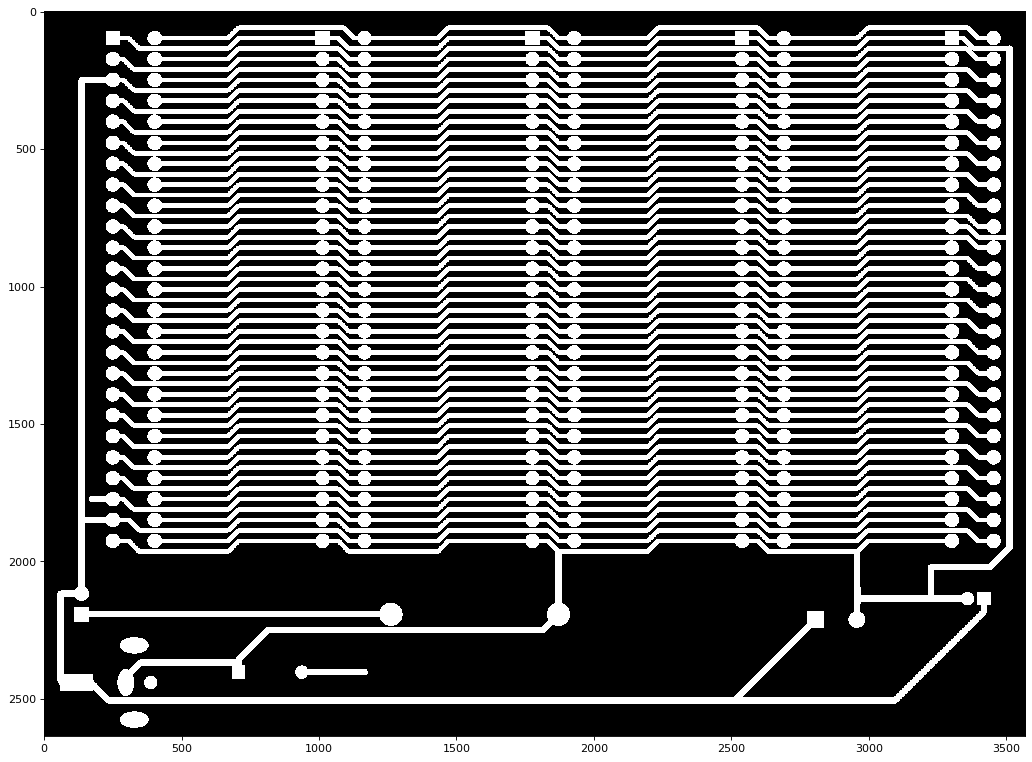

In [10]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(blank_image)
plt.show()